# Mini ML Project

In [36]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as mse
from functools import partial
from bisect import bisect


## The data

In [37]:
data = pd.read_csv('dataset.csv')
display(data)

,molecule_id,pXC50,b0001,b0002,b0003,b0004,b0005,b0006,b0007,b0008,...,b1015,b1016,b1017,b1018,b1019,b1020,b1021,b1022,b1023,b1024
0,CHEMBL10016,7.301,1,1,1,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1,CHEMBL10019,6.071,1,1,1,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
2,CHEMBL10092,5.357,1,1,1,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
3,CHEMBL100954,7.260,1,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL101069,7.616,1,1,1,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166,CHEMBL96723,7.480,1,1,1,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1167,CHEMBL96746,7.572,1,1,1,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1168,CHEMBL96831,5.439,1,1,1,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1169,CHEMBL96906,6.325,1,1,1,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0


## Useful Functions

In [38]:
# For reproducibility use a random state of 1
def split(df, random_state=1):
    train, test = train_test_split(df, random_state=1)
    x_train = train.drop(["molecule_id", "pXC50"], axis=1)
    x_test = test.drop(["molecule_id", "pXC50"], axis=1)
    y_train = train["pXC50"]
    y_test = test["pXC50"]
    return x_train, x_test, y_train, y_test

## Clean

In [52]:
temp = data.drop(["molecule_id", "pXC50"], axis=1)
for col in temp.columns:
    if len(data[col].unique()) == 1:
        data = data.drop(col, axis=1)
display(data)
data["b1024"].sum()

,molecule_id,pXC50,b0002,b0004,b0005,b0006,b0007,b0008,b0009,b0011,...,b1012,b1013,b1015,b1016,b1017,b1018,b1019,b1020,b1021,b1024
0,CHEMBL10016,7.301,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,CHEMBL10019,6.071,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,CHEMBL10092,5.357,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,CHEMBL100954,7.260,1,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,CHEMBL101069,7.616,1,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166,CHEMBL96723,7.480,1,0,1,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,0
1167,CHEMBL96746,7.572,1,0,1,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,0
1168,CHEMBL96831,5.439,1,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1169,CHEMBL96906,6.325,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


2

## Cross Validation

## K nearest neighbours regression

In [40]:
x_train, x_test, y_train, y_test = split(data)

## Own Code
def getNearest(X, x):
    smallest = []
    index = []
    for i in range(X.shape[0]):
        temp = -np.linalg.norm(x-X[i])
        insertAt = bisect(smallest, temp)
        smallest.insert(insertAt, temp)
        index.insert(insertAt, i)
    return index

def trainKNN(X, Y):
    _mse = []
    errors = []
    nearest = []
    for i in range(X.shape[0]):
        nearest.append(getNearest(np.delete(X, i, axis=0), X[i]))
        print(f"\r{i} out of {len(Y)}", end="")
    for i in range(X.shape[0]-1):
        yguess = []
        for j in range(X.shape[0]):
            yguess.append(np.mean(Y[nearest[j]]))
            nearest[j].pop(0)
        _mse.append(mse(yguess, Y))
        print(f'\r{i} down with {len(nearest[0])} left. Most recent mse = {_mse[-1]}', end="")
    

    return _mse



p1 = int() # Number of neighbours to consider
X = np.array(x_train)
Y = np.array(y_train)

meanErrors = trainKNN(X, Y)




876 down with 0 left. Most recent mse = 2.2227373371298405

12


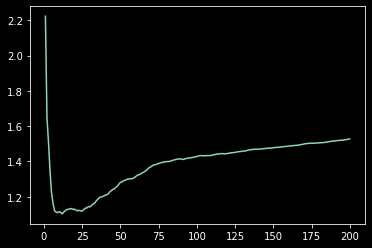

In [41]:
from matplotlib.pyplot import *
x = [i for i in range(X.shape[0]-1, 0, -1)]
plot(x[-200:], meanErrors[-200:])
K = x[np.argmin(meanErrors)]
print(K)

In [42]:
def KNN(X_train, Y_train, x, K):
    X_record = K * [-float("inf")]
    Y_record = K * [None]
    for i in range(X_train.shape[0]):
        diff = -np.linalg.norm(X_train[i] - x)
        if diff > X_record[0]:
            X_record.pop(0)
            Y_record.pop(0)
            index = bisect(X_record, diff)
            X_record.insert(index, diff)
            Y_record.insert(index, Y_train[i])
    return np.mean(Y_record)

y_pred = []
for x in np.array(x_test):
    y_pred.append(KNN(X, Y, x, K))

mse(y_pred, y_test)


0.5529321534414107

In [43]:
KNN_Classifier = KNeighborsRegressor(K)
KNN_Classifier.fit(x_train, y_train)
y_pred = KNN_Classifier.predict(x_test)
mse(y_pred, y_test)

0.5489512646947289

## Decision Tree

In [44]:
x_train, x_test, y_train, y_test = split(data)


## Random Forrest

In [45]:
x_train, x_test, y_train, y_test = split(data)
X.shape[0]

878

## Regression

In [46]:
x_train, x_test, y_train, y_test = split(data)

X_train = np.array(x_train)
Y_train = np.array(y_train)
import statsmodels.api as sm
X2 = sm.add_constant(X_train)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
display(est2.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     12.67
Date:                Fri, 01 Oct 2021   Prob (F-statistic):          8.57e-108
Time:                        14:45:09   Log-Likelihood:                -172.19
No. Observations:                 878   AIC:                             1402.
Df Residuals:                     349   BIC:                             3930.
Df Model:                         528                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7970      0.684      2.627      0.009       0.452       3.142
x1             2.1287      1.163      1.831      0.068      -0.158       4.415
x2            -0.0070      0.896     -0.008      0.994      -1.769       1.755
x3             1.2282      0.634      1.938      0.053      -0.018       2.474
x4             0.3875      1.087      0.356      0.722      -1.750       2.525
x5             1.3214      0.724      1.824      0.069      -0.103       2.746
x6            -1.5024      0.823     -1.825      0.069      -3.121       0.117
x7            -0.1765      2.055     -0.086      0.932      -4.218       3.866
x8            -0.6437      2.115     -0.304      0.761      -4.804       3.516
x9            -1.9882      1.213     -1.639      0.102      -4.374       0.397
x10           -1.7942      2.595     -0.691      0.490      -6.898       3.309
x11           -0.3414      0.754     -0.453      0.651      -1.825       1.142
x12            0.5992      1.625      0.369      0.712      -2.596       3.794
x13            0.1159      1.122      0.103      0.918      -2.092       2.323
x14            2.1396      1.879      1.139      0.255      -1.555       5.834
x15           -2.5461      2.271     -1.121      0.263      -7.013       1.920
x16           -0.7753      2.630     -0.295      0.768      -5.948       4.397
x17            0.1701      0.727      0.234      0.815      -1.261       1.601
x18            2.5865      2.915      0.887      0.376      -3.148       8.321
x19           -0.4555      1.572     -0.290      0.772      -3.547       2.636
x20            1.6172      1.132      1.429      0.154      -0.609       3.843
x21           -0.4213      2.626     -0.160      0.873      -5.586       4.744
x22            1.1168      0.539      2.072      0.039       0.057       2.177
x23           -0.3108      1.245     -0.250      0.803      -2.759       2.137
x24           -1.0165      3.239     -0.314      0.754      -7.387       5.354
x25           -2.2361      1.392     -1.606      0.109      -4.975       0.502
x26            2.4625      2.517      0.978      0.329      -2.489       7.414
x27            0.9028      0.620      1.457      0.146      -0.316       2.122
x28           -2.6548      2.363     -1.123      0.262      -7.302       1.993
x29            2.4327      1.943      1.252      0.211      -1.389       6.254
x30            2.4380      0.887      2.749      0.006       0.694       4.182
x31           -0.1016      0.886     -0.115      0.909      -1.844       1.641
x32           -0.0491      0.953     -0.052      0.959      -1.924       1.826
x33            3.2954      2.999      1.099      0.273      -2.603       9.194
x34         8.434e-14   3.29e-13      0.256      0.798   -5.63e-13    7.31e-13
x35           -0.3412      1.429     -0.239      0.811      -3.151       2.469
x3